In [1]:
import numpy as np
import scanpy as sc
import torch
import random
import pandas as pd
import SpaGCN as spg

from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from anndata import AnnData

In [3]:
bayes_space_results = pd.read_csv("../BayesSpace_comparison/BayesSpace_clustering_results.csv", index_col=0, header=0)

In [4]:
coordinates = np.loadtxt("../data/SpaGCN_spatialLIBD/files/coordinates_151673.txt")
labels = np.loadtxt("../data/SpaGCN_spatialLIBD/files/labels_151673.txt", dtype="str")
x, y = coordinates.T

In [5]:
adjacency_matrix = spg.calculate_adj_matrix(x=x, y=y, histology=False)

Calculateing adj matrix using xy only...


In [6]:
adjusted_rand_score(bayes_space_results["x"].values, labels)

0.5387814751043232

## Refined clustering for BayesSpace (loop the below 2 cells)

In [7]:
refined_bayes_space = spg.refine(sample_id=bayes_space_results.index.tolist(), pred=bayes_space_results["refined_x"].tolist(), dis=adjacency_matrix, shape="hexagon")
bayes_space_results["refined_x"] = refined_bayes_space

KeyError: 'refined_x'

In [ ]:
adjusted_rand_score(bayes_space_results["refined_x"].values, labels)

## SpaGCN Setup

In [8]:
# https://github.com/jianhuupenn/SpaGCN/blob/359a0c56e5b78d2460ac5636223da38f662c14c5/SpaGCN_package/SpaGCN/util.py#L59
def search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100):
    run=0
    p_low=calculate_p(adj, start)
    p_high=calculate_p(adj, end)
    if p_low>p+tol:
        print("l not found, try smaller start point.")
        return None
    elif p_high<p-tol:
        print("l not found, try bigger end point.")
        return None
    elif  np.abs(p_low-p) <=tol:
        print("recommended l = ", str(start))
        return start
    elif  np.abs(p_high-p) <=tol:
        print("recommended l = ", str(end))
        return end
    while (p_low+tol)<p<(p_high-tol):
        run+=1
        print("Run "+str(run)+": l ["+str(start)+", "+str(end)+"], p ["+str(p_low)+", "+str(p_high)+"]")
        if run >max_run:
            print("Exact l not found, closest values are:\n"+"l="+str(start)+": "+"p="+str(p_low)+"\nl="+str(end)+": "+"p="+str(p_high))
            return None
        mid=(start+end)/2
        p_mid=calculate_p(adj, mid)
        if np.abs(p_mid-p)<=tol:
            print("recommended l = ", str(mid))
            return mid
        if p_mid<=p:
            start=mid
            p_low=p_mid
        else:
            end=mid
            p_high=p_mid

In [9]:
def calculate_p(adj, l):
    adj_exp=np.exp(-1*(adj**2)/(2*(l**2)))
    return np.mean(np.sum(adj_exp,1))-1

In [10]:
def search_radius(target_cluster,cell_id, adj, x, y, pred, start, end, num_min=8, num_max=15,  max_run=100):
    run=0
    num_low=count_nbr(target_cluster,cell_id, adj, x, y, pred, start)
    num_high=count_nbr(target_cluster,cell_id, adj, x, y, pred, end)
    if num_min<=num_low<=num_max:
        print("recommended radius = ", str(start))
        return start
    elif num_min<=num_high<=num_max:
        print("recommended radius = ", str(end))
        return end
    elif num_low>num_max:
        print("Try smaller start.")
        return None
    elif num_high<num_min:
        print("Try bigger end.")
        return None
    while (num_low<num_min) and (num_high>num_min):
        run+=1
        print("Run "+str(run)+": radius ["+str(start)+", "+str(end)+"], num_nbr ["+str(num_low)+", "+str(num_high)+"]")
        if run >max_run:
            print("Exact radius not found, closest values are:\n"+"radius="+str(start)+": "+"num_nbr="+str(num_low)+"\nradius="+str(end)+": "+"num_nbr="+str(num_high))
            return None
        mid=(start+end)/2
        num_mid=count_nbr(target_cluster,cell_id, adj, x, y, pred, mid)
        if num_min<=num_mid<=num_max:
            print("recommended radius = ", str(mid), "num_nbr="+str(num_mid))
            return mid
        if num_mid<num_min:
            start=mid
            num_low=num_mid
        elif num_mid>num_max:
            end=mid
            num_high=num_mid

In [11]:
def count_nbr(target_cluster, cell_id, adj, x, y, pred, radius):
    cluster_num = dict()
    df = {'cell_id': cell_id, 'x': x, "y":y, "pred":pred}
    df = pd.DataFrame(data=df)
    df.index=df['cell_id']
    target_df=df[df["pred"]==target_cluster]
    row_index=0
    num_nbr=[]
    for index, row in target_df.iterrows():
        x=row["x"]
        y=row["y"]
        tmp_nbr=df[((df["x"]-x)**2+(df["y"]-y)**2)<=(radius**2)]
        num_nbr.append(tmp_nbr.shape[0])
    return np.mean(num_nbr)

## spatialLIBD dataset

In [5]:
gene_expression = np.loadtxt("../data/SpaGCN_spatialLIBD/files/expression_151673.txt")
adata = AnnData(gene_expression)
gene_names = np.loadtxt("../data/SpaGCN_spatialLIBD/files/genes_151673.txt", dtype=str)

In [6]:
adata.obs["x_pixel"] = x
adata.obs["y_pixel"] = y
adata.var_names = gene_names

NameError: name 'x' is not defined

In [ ]:
spg.prefilter_genes(adata, min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [ ]:
p=0.5 
#Find the l value given p
l = search_l(p, adjacency_matrix, start=0.01, end=1000, tol=0.01, max_run=100)

In [ ]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=50
#Search for suitable resolution
res = spg.search_res(adata, adjacency_matrix, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

In [ ]:
clf = spg.SpaGCN()
clf.set_l(l)

In [ ]:
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

In [ ]:
#Run
clf.train(adata, adjacency_matrix, init_spa=True, init="louvain", res=res, tol=5e-3, lr=0.05, max_epochs=1000)

y_pred, prob = clf.predict()
adata.obs["pred"] = y_pred
adata.obs["pred"] = adata.obs["pred"].astype('category')

In [ ]:
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
refined_pred = spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adjacency_matrix, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')

In [ ]:
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains = "pred"
num_celltype = len(adata.obs[domains].unique())
adata.uns[domains+"_colors"] = list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata, alpha=1,x="y_pixel",y="x_pixel", color=domains, title=domains, color_map=plot_color, show=False, size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel", color=domains, title=domains, color_map=plot_color, show=False, size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

In [ ]:
adjusted_rand_score(adata.obs["refined_pred"].values, labels)

In [ ]:
#Use domain 0 as an example
domain_labels = list(range(7))

#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5

nonzero_index = (adjacency_matrix!=0)
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
start, end = np.quantile(adjacency_matrix[nonzero_index],q=0.001), np.quantile(adjacency_matrix[nonzero_index], q=0.1)
SVGs = []
for target in domain_labels:
    r=search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), adj=adjacency_matrix, x=x, y=y, pred=adata.obs["pred"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)
    #Detect neighboring domains
    nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                       cell_id=adata.obs.index.tolist(), 
                                       x=adata.obs["x_pixel"].tolist(), 
                                       y=adata.obs["y_pixel"].tolist(), 
                                       pred=adata.obs["pred"].tolist(),
                                       radius=r,
                                       ratio=1/2)

    nbr_domians=nbr_domians[0:3]
    de_genes_info=spg.rank_genes_groups(input_adata=adata,
                                    target_cluster=target,
                                    nbr_list=nbr_domians, 
                                    label_col="pred", 
                                    adj_nbr=True, 
                                    log=True)
    #Filter genes
    de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
    filtered_info=de_genes_info
    filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                                (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                                (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                                (filtered_info["fold_change"]>min_fold_change)]
    filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
    filtered_info["target_dmain"]=target
    filtered_info["neighbors"]=str(nbr_domians)
    print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())
    SVGs.append(filtered_info["genes"].tolist())

In [ ]:
target=1
meta_name, meta_exp = spg.find_meta_gene(input_adata=adata,
                    pred=adata.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="GFAP",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=3,
                    use_raw=False)

adata.obs["meta"] = meta_exp

In [ ]:
color_self = LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)

#Plot meta gene
gene = "GFAP"
adata.obs["exp"] = adata.X[:, adata.var.index == gene]
ax = sc.pl.scatter(adata, alpha=1, x="y_pixel", y="x_pixel", color="exp",title=gene, color_map=color_self, show=False, size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

adata.obs["exp"]=adata.obs["meta"]
ax = sc.pl.scatter(adata, alpha=1, x="y_pixel", y="x_pixel", color="exp",title=meta_name,color_map=color_self, show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

## STARmap dataset

In [12]:
gene_expression = np.load("../STARmap_2018/files/expression_visual_1020_20180410-BY3_1kgenes.pkl", allow_pickle=True)
adata = AnnData(gene_expression)
gene_names = np.loadtxt("../STARmap_2018/files/genes_visual_1020_20180410-BY3_1kgenes.txt", dtype=str)

In [13]:
coordinates = np.loadtxt("../STARmap_2018/files/coordinates_visual_1020_20180410-BY3_1kgenes.txt")
labels = np.loadtxt("../STARmap_2018/files/labels_visual_1020_20180410-BY3_1kgenes.txt", dtype="str")
x, y = coordinates.T

In [14]:
adjacency_matrix = spg.calculate_adj_matrix(x=x, y=y, histology=False)

Calculateing adj matrix using xy only...


In [15]:
adata.obs["x_pixel"] = x
adata.obs["y_pixel"] = y
adata.var_names = gene_names

In [16]:
spg.prefilter_genes(adata, min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [17]:
p=0.5 
#Find the l value given p
l = search_l(p, adjacency_matrix, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 73.02743865988917]
Run 2: l [0.01, 500.005], p [0.0, 21.67870330810547]
Run 3: l [0.01, 250.0075], p [0.0, 5.707661151885986]
Run 4: l [0.01, 125.00874999999999], p [0.0, 1.192328929901123]
Run 5: l [62.509375, 125.00874999999999], p [0.11237502098083496, 1.192328929901123]
Run 6: l [62.509375, 93.7590625], p [0.11237502098083496, 0.5251157283782959]
Run 7: l [78.13421875, 93.7590625], p [0.28219711780548096, 0.5251157283782959]
Run 8: l [85.946640625, 93.7590625], p [0.39522767066955566, 0.5251157283782959]
Run 9: l [89.8528515625, 93.7590625], p [0.45814383029937744, 0.5251157283782959]
recommended l =  91.80595703125


In [18]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=16
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res = spg.search_res(adata, adjacency_matrix, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
Initializing cluster centers with louvain, resolution =  0.7999999999999999


/home/shahula/bin/miniconda3/envs/multimodal/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  7
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  8
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  8
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
Res =  1.0999999999999999 Num of clusters =  9
Res changed to 1.0999999999999999
Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Res =  1.2 Num of clusters =  10
Res changed to 1.2
Initializing cluster centers with louvain, resolution =  1.3
Epoch  0
Epoch  10
Res =  1.3 Num of clusters =  10
Res changed to 1.3
Initializing cluster centers with louvain, resolution =  1.4000000000000001
Epoch  0
Epoch  10
Res =  1.4000

In [19]:
clf = spg.SpaGCN()
clf.set_l(l)

In [20]:
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

In [21]:
#Run
clf.train(adata, adjacency_matrix, init_spa=True, init="louvain", res=res, tol=5e-3, lr=0.05, max_epochs=1000)

y_pred, prob = clf.predict()
adata.obs["pred"] = y_pred
adata.obs["pred"] = adata.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  1.9000000000000006
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.0032258064516129032 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 34


In [22]:
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
refined_pred = spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adjacency_matrix, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')

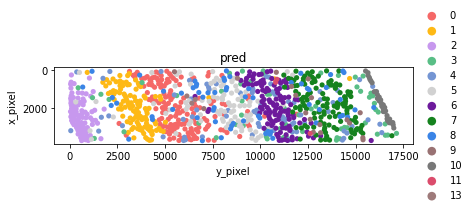

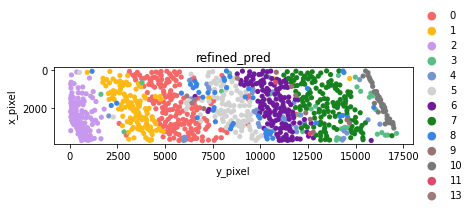

In [23]:
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains = "pred"
num_celltype = len(adata.obs[domains].unique())
adata.uns[domains+"_colors"] = list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata, alpha=1,x="y_pixel",y="x_pixel", color=domains, title=domains, color_map=plot_color, show=False, size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel", color=domains, title=domains, color_map=plot_color, show=False, size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

In [26]:
adjusted_rand_score(adata.obs["pred"].values, labels)

0.45615084923041943

In [47]:
#Use domain 0 as an example
domain_labels = list(range(15))

#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5

nonzero_index = (adjacency_matrix!=0)
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
start, end = np.quantile(adjacency_matrix[nonzero_index],q=0.001), np.quantile(adjacency_matrix[nonzero_index], q=0.1)
SVGs = []
for target in domain_labels:
    r=search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), adj=adjacency_matrix, x=x, y=y, pred=adata.obs["pred"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)
    #Detect neighboring domains
    nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                       cell_id=adata.obs.index.tolist(), 
                                       x=adata.obs["x_pixel"].tolist(), 
                                       y=adata.obs["y_pixel"].tolist(), 
                                       pred=adata.obs["pred"].tolist(),
                                       radius=r * 2,
                                       ratio=1/2)

    nbr_domians=nbr_domians[0:3]
    de_genes_info=spg.rank_genes_groups(input_adata=adata,
                                    target_cluster=target,
                                    nbr_list=nbr_domians, 
                                    label_col="pred", 
                                    adj_nbr=True, 
                                    log=True)
    #Filter genes
    de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
    filtered_info=de_genes_info
    filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                                (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                                (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                                (filtered_info["fold_change"]>min_fold_change)]
    filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
    filtered_info["target_dmain"]=target
    filtered_info["neighbors"]=str(nbr_domians)
    print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())
    SVGs.append(filtered_info["genes"].tolist())

Run 1: radius [164.7478447113037, 1554.0098876953125], num_nbr [2.2410714285714284, 97.375]
Run 2: radius [164.7478447113037, 859.3788662033081], num_nbr [2.2410714285714284, 35.830357142857146]
Run 3: radius [164.7478447113037, 512.0633554573059], num_nbr [2.2410714285714284, 14.098214285714286]
Run 4: radius [338.4056000843048, 512.0633554573059], num_nbr [6.642857142857143, 14.098214285714286]
Run 5: radius [425.23447777080537, 512.0633554573059], num_nbr [9.571428571428571, 14.098214285714286]
recommended radius =  468.6489166140556 num_nbr=11.839285714285714
radius= 468.6489166140556 average number of neighbors for each spot is 11.839285714285714
 Cluster 0 has neighbors:
Dmain  9 :  75
Dmain  14 :  26
SVGs for domain  0 : ['Mbp', 'Kif5a', 'Plp1', 'Mobp', 'Qk', 'Dusp6', 'Sept4']
Run 1: radius [164.7478447113037, 1554.0098876953125], num_nbr [2.5977011494252875, 76.816091954023]
Run 2: radius [164.7478447113037, 859.3788662033081], num_nbr [2.5977011494252875, 37.52873563218391]
Ru

TypeError: 'NoneType' object is not subscriptable

In [48]:
target=1
meta_name, meta_exp = spg.find_meta_gene(input_adata=adata,
                    pred=adata.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="GFAP",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=3,
                    use_raw=False)

adata.obs["meta"] = meta_exp

ValueError: Wrong number of items passed 0, placement implies 1

In [49]:
color_self = LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)

#Plot meta gene
gene = "GFAP"
adata.obs["exp"] = adata.X[:, adata.var.index == gene]
ax = sc.pl.scatter(adata, alpha=1, x="y_pixel", y="x_pixel", color="exp",title=gene, color_map=color_self, show=False, size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

adata.obs["exp"]=adata.obs["meta"]
ax = sc.pl.scatter(adata, alpha=1, x="y_pixel", y="x_pixel", color="exp",title=meta_name,color_map=color_self, show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.show()
plt.close()

ValueError: Wrong number of items passed 0, placement implies 1